#MODELLING 


# Introduction


For this iteration we have implemented a few existing models with transfer learning: 
- VGG16
- VGG19
- ResNet50
- EfficientNet

At this stage, only 3 genus have been used instead of 35 to quickly compare the different models. The number of genus will be increased once the best models are found. 


### Settings

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Settings
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

GDRIVE_MOUNT_POINT = '/content/drive'
PROJECT_DIR = GDRIVE_MOUNT_POINT + '/MyDrive/Mushroom_project' 
PY_LIB_DIR = PROJECT_DIR + '/src/lib'
SRC_DIR = PROJECT_DIR + '/datasource/mushroomObserver/dataframe/clean'

IMG_DIR=PROJECT_DIR + "/datasource/mushroomObserver/images"

WORK_DIR = "/content/drive/MyDrive/work/Oliv/images"
WORK_DIR_DAD= "/content/drive/MyDrive/work/dad/transfert/images"

### Import libraries

In [ ]:
# Importing standard libraries
#
from google.colab import drive
import os
from shutil import copyfile, rmtree
from skimage import io
import sys
import numpy as np
import pandas as pd

import urllib.request

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.colab.patches import cv2_imshow
import cv2
from skimage import io

import random

from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Conv2D,  Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPool2D
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
 

In [ ]:
# Optional - Pre-requisites 
#
# Mounting Google drive if not already done
if not os.path.isdir(GDRIVE_MOUNT_POINT):
  drive.mount(GDRIVE_MOUNT_POINT)


In [ ]:
#Optional - Test if GPU 
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Sat May  1 11:49:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    34W / 250W |    349MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

### Loading Data

In [ ]:
# Loading Data

df_genus = pd.read_csv( \
      filepath_or_buffer = SRC_DIR + '/' + "df_genus.csv"
   ,  sep = ','
   ,  header = 0
)

#specify image link within Google Drive
for i in range(len(df_genus)):
#  link= getFilepathFromImageId(int(df_genus.loc[i,"image_id"]),"jpg", imageRootDir=WORK_DIR_DAD)
  df_genus.loc[i,"img_path"]= WORK_DIR + "/" + df_genus.loc[i,"taxon_name"] + "/" + str(int(df_genus.loc[i,"image_id"]))+".jpg"


In [ ]:
#filter specific nb of genus for test purposes
filtre_genus=df_genus.taxon_name.value_counts().index[:3]
#filtre_genus=["Cantharellus", "Entoloma", "Tylopilus"]
df_genus=df_genus[df_genus["taxon_name"].isin(filtre_genus)].reset_index()

#Prepare train and test sets
X=df_genus[df_genus["taxon_name"].isin(filtre_genus)][["img_path","taxon_name"]]
X_train, X_test = train_test_split(X, test_size=0.2)


In [ ]:
#['Gymnopus', 'Laccaria', 'Boletus']
filtre_genus

Index(['Lepiota', 'Tylopilus', 'Hygrocybe'], dtype='object')

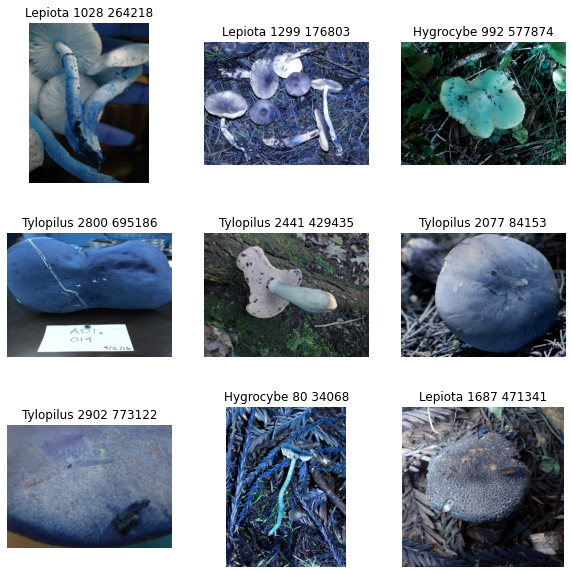

In [ ]:
#Show 9 mushrooms randomly
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  k=random.randint(0,df_genus.shape[0])
  img=cv2.imread(df_genus.img_path[k], cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title(df_genus.taxon_name[k]+ " "  + str(k) +" "+ str(int(df_genus.image_id[k])))
  plt.axis("off")

# VGG16

##Create VGG16 Generators

In [ ]:
# VGG16 model also expects images to be centered. That is,
# to have the mean pixel values from each channel (red, green, and blue) 
# as calculated on the ImageNet training dataset subtracted from the input. 
# Keras provides a function to perform this preparation for individual photos
# via the preprocess_input() function. Nevertheless, we can achieve the same
# effect with the ImageDataGenerator by setting the “featurewise_center” argument
# to “True” and manually specifying the mean pixel values to use when centering
# as the mean values from the ImageNet training dataset: [123.68, 116.779, 103.939].

#datagen= keras.preprocessing.image.ImageDataGenerator(featurewise_center=True)
#datagen.mean = [123.68, 116.779, 103.939]
#This should be the same :
datagen= keras.preprocessing.image.ImageDataGenerator(preprocessing_function= keras.applications.vgg16.preprocess_input)

batch_size=32

#VGG16 needs images of size 224x224 
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="", 
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=(224,224), batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=(224,224), batch_size=batch_size)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


##VGG16 - Baseline

In [ ]:
#VGG16 WITH TRANSFER LEARNING

from keras.applications import VGG16

base_model=VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
#as include_top=False : pre-trained weights are only downloaded for convolution layers and no weights are downloaded for dense layers
#remove classifier
for layer in base_model.layers:
  layer.trainable = False
VGG16_v1 = Sequential()
VGG16_v1.add(base_model)
VGG16_v1.add(GlobalAveragePooling2D())
VGG16_v1.add(Dense(1024,activation="relu"))
VGG16_v1.add(Dropout(rate=0.2))
VGG16_v1.add(Dense(512,activation="relu"))
VGG16_v1.add(Dropout(rate=0.2))
VGG16_v1.add(Dense(len(filtre_genus),activation="softmax"))
VGG16_v1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_VGG16_v1= VGG16_v1.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                                    callbacks=[callback],validation_data=test_generator, validation_steps=test_generator.n//batch_size)

steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 20s 259ms/step - loss: 1.6274 - accuracy: 0.6352 - val_loss: 0.4421 - val_accuracy: 0.8281
Epoch 2/10
75/75 [==============================] - 19s 253ms/step - loss: 0.3619 - accuracy: 0.8555 - val_loss: 0.4735 - val_accuracy: 0.8247
Epoch 3/10
75/75 [==============================] - 19s 254ms/step - loss: 0.3088 - accuracy: 0.8698 - val_loss: 0.4281 - val_accuracy: 0.8438
Epoch 4/10
75/75 [==============================] - 19s 253ms/step - loss: 0.2358 - accuracy: 0.8986 - val_loss: 0.4872 - val_accuracy: 0.8420
Epoch 5/10
75/75 [==============================] - 19s 255ms/step - loss: 0.1629 - accuracy: 0.9365 - val_loss: 0.4951 - val_accuracy: 0.8455
Epoch 6/10
75/75 [==============================] - 19s 254ms/step - loss: 0.1449 - accuracy: 0.9439 - val_loss: 0.4868 - val_accuracy: 0.8681
Epoch 7/10
75/75 [==============================] - 19s 255ms/step - loss: 0.0742 - accuracy: 0.9752 - val_loss: 0.5557 - val_accuracy: 0.8611

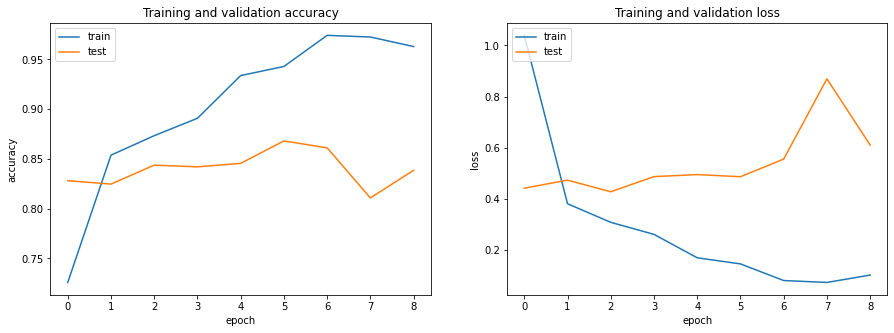

19/19 [==============================] - 4s 205ms/step
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       190
           1       0.74      0.89      0.81       203
           2       0.96      0.86      0.91       207

    accuracy                           0.83       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.83      0.83       600



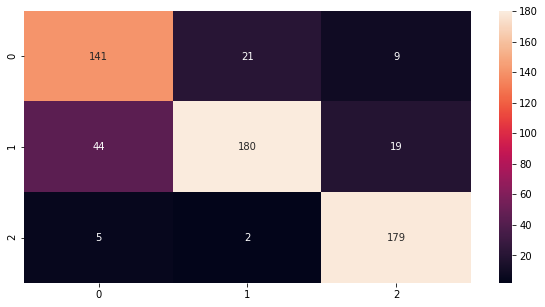

In [ ]:
show_performance(VGG16_v1, history_VGG16_v1)

19/19 [==============================] - 4s 207ms/step


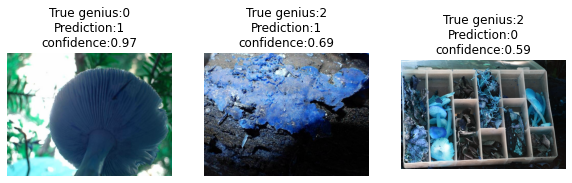

In [ ]:
 show_wrong_predictions(VGG16_v1)

Conclusion : validation accuracy is 84% which is already good for a first model ! We observe overfitting appearing after epoch 1. 

Uncorrect predictions seem to be most of the time images where there's no mushroom. => We need to design a function that will filter images

##VGG16 - Transfer learning v2

In [ ]:
#VGG16 WITH TRANSFER LEARNING et UNFREEZE

from keras.applications import VGG16

base_model=VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
#as include_top=False : pre-trained weights are only downloaded for convolution layers and no weights are downloaded for dense layers
for layer in base_model.layers:
  layer.trainable = False
VGG16_v2 = Sequential()
VGG16_v2.add(base_model)
VGG16_v2.add(Flatten())
VGG16_v2.add(Dropout(rate=0.2))
VGG16_v2.add(Dense(len(filtre_genus),activation="softmax"))

VGG16_v2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_VGG16_v2= VGG16_v2.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                                  callbacks=[callback],validation_data=test_generator, validation_steps=test_generator.n//batch_size)

steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 20s 256ms/step - loss: 9.6144 - accuracy: 0.6399 - val_loss: 6.1276 - val_accuracy: 0.8212
Epoch 2/10
75/75 [==============================] - 19s 251ms/step - loss: 1.8551 - accuracy: 0.9075 - val_loss: 6.2069 - val_accuracy: 0.8299
Epoch 3/10
75/75 [==============================] - 19s 251ms/step - loss: 0.7902 - accuracy: 0.9510 - val_loss: 7.1876 - val_accuracy: 0.7951
Epoch 4/10
75/75 [==============================] - 19s 253ms/step - loss: 0.8542 - accuracy: 0.9623 - val_loss: 6.9478 - val_accuracy: 0.8160
Epoch 5/10
75/75 [==============================] - 19s 254ms/step - loss: 0.4501 - accuracy: 0.9729 - val_loss: 9.0873 - val_accuracy: 0.8160
Epoch 6/10
75/75 [==============================] - 19s 253ms/step - loss: 0.7021 - accuracy: 0.9647 - val_loss: 10.7078 - val_accuracy: 0.8108
Epoch 7/10
75/75 [==============================] - 19s 254ms/step - loss: 0.4935 - accuracy: 0.9791 - val_loss: 8.2356 - val_accuracy: 0.819

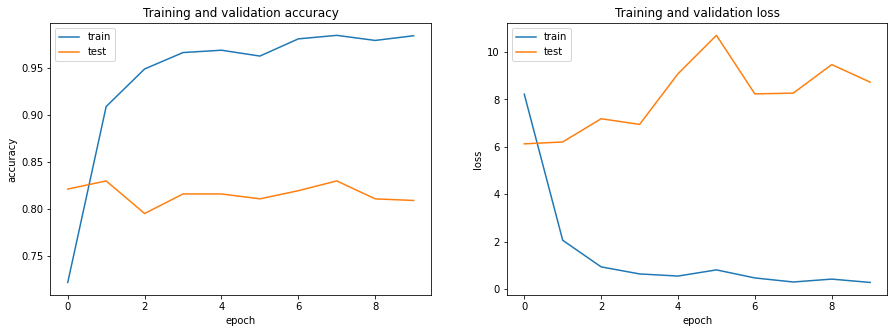

19/19 [==============================] - 4s 207ms/step
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       190
           1       0.80      0.77      0.79       203
           2       0.91      0.87      0.89       207

    accuracy                           0.81       600
   macro avg       0.81      0.80      0.80       600
weighted avg       0.81      0.81      0.81       600



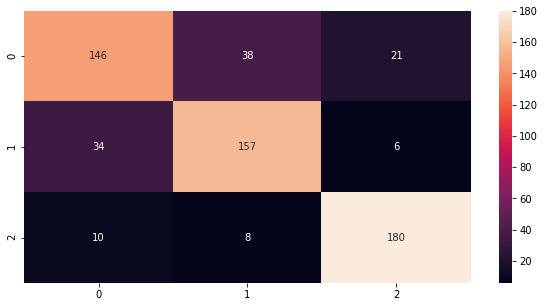

In [ ]:
show_performance(VGG16_v2, history_VGG16_v2)

19/19 [==============================] - 4s 205ms/step


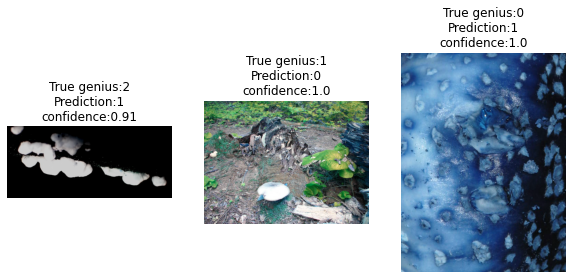

In [ ]:
show_wrong_predictions(VGG16_v2)

Conclusion : validation accuracy is 81% which is less than the first model. We observe overfitting appearing after epoch 1. 

Uncorrect predictions seem to be most of the time images where there's no mushroom. => We need to design a function that will filter images

Class 0 has the lowest accuracy, this should be analyzed 

##VGG16 - Transfer learning v3

In [ ]:
#VGG16 WITH TRANSFER LEARNING et UNFREEZE

from keras.applications import VGG16

base_model=VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
#as include_top=False : pre-trained weights are only downloaded for convolution layers and no weights are downloaded for dense layers
for layer in base_model.layers:
  layer.trainable = False
VGG16_v3 = Sequential()
VGG16_v3.add(base_model)
VGG16_v3.add(GlobalAveragePooling2D())
VGG16_v3.add(Dropout(rate=0.8))
VGG16_v3.add(Dense(len(filtre_genus),activation="softmax"))

VGG16_v3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_VGG16_v3= VGG16_v3.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                               callbacks=[callback],validation_data=test_generator, validation_steps=test_generator.n//batch_size)

steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 20s 259ms/step - loss: 10.1623 - accuracy: 0.3598 - val_loss: 1.9405 - val_accuracy: 0.6337
Epoch 2/10
75/75 [==============================] - 19s 253ms/step - loss: 6.1847 - accuracy: 0.4934 - val_loss: 1.3023 - val_accuracy: 0.7188
Epoch 3/10
75/75 [==============================] - 19s 253ms/step - loss: 4.0035 - accuracy: 0.5752 - val_loss: 1.0997 - val_accuracy: 0.7517
Epoch 4/10
75/75 [==============================] - 19s 253ms/step - loss: 3.0235 - accuracy: 0.6119 - val_loss: 0.9453 - val_accuracy: 0.7639
Epoch 5/10
75/75 [==============================] - 19s 253ms/step - loss: 2.2653 - accuracy: 0.6433 - val_loss: 0.7811 - val_accuracy: 0.8021
Epoch 6/10
75/75 [==============================] - 19s 254ms/step - loss: 1.7242 - accuracy: 0.6570 - val_loss: 0.6879 - val_accuracy: 0.7986
Epoch 7/10
75/75 [==============================] - 19s 254ms/step - loss: 1.4154 - accuracy: 0.6891 - val_loss: 0.6642 - val_accuracy: 0.805

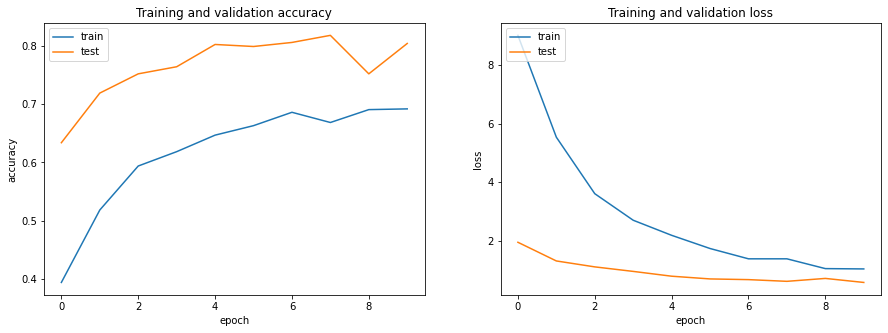

19/19 [==============================] - 4s 207ms/step
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       190
           1       0.82      0.71      0.76       203
           2       0.85      0.91      0.88       207

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600



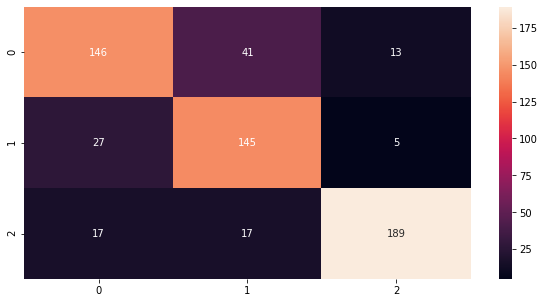

In [ ]:
show_performance(VGG16_v3, history_VGG16_v3)

19/19 [==============================] - 4s 204ms/step


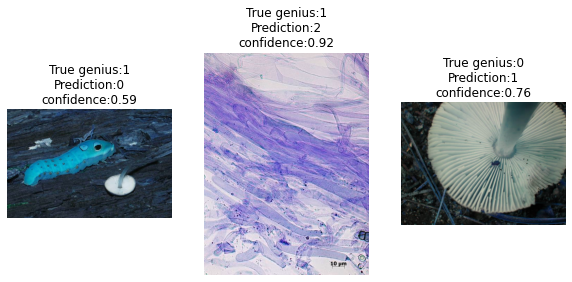

In [ ]:
show_wrong_predictions(VGG16_v3)

Conclusion : validation accuracy is 80% . However the accuracy has not converged and more epochs should be used (50 instead of 10?). 

Uncorrect predictions seem to be most of the time images where there's no mushroom. => We need to design a function that will filter images

##VGG16 - Transfer learning v4

In [ ]:
#VGG16 WITH TRANSFER LEARNING 
#https://thedatafrog.com/en/articles/image-recognition-transfer-learning/

from keras.applications import VGG16

base_model=VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
#as include_top=False : pre-trained weights are only downloaded for convolution layers and no weights are downloaded for dense layers
for layer in base_model.layers:
  layer.trainable = False
VGG16_v4 = Sequential()
VGG16_v4.add(base_model)
VGG16_v4.add(Flatten())
VGG16_v4.add(Dense(100, activation="relu"))
VGG16_v4.add(Dense(100, activation="relu"))
VGG16_v4.add(Dense(100, activation="relu"))
VGG16_v4.add(Dense(len(filtre_genus),activation="softmax"))

VGG16_v4.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_VGG16_v4= VGG16_v4.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                             callbacks=[callback], validation_data=test_generator, validation_steps=test_generator.n//batch_size)

steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 21s 258ms/step - loss: 2.7562 - accuracy: 0.6439 - val_loss: 1.5142 - val_accuracy: 0.7569
Epoch 2/10
75/75 [==============================] - 19s 252ms/step - loss: 0.4664 - accuracy: 0.8898 - val_loss: 1.1215 - val_accuracy: 0.7882
Epoch 3/10
75/75 [==============================] - 19s 252ms/step - loss: 0.2062 - accuracy: 0.9458 - val_loss: 1.1215 - val_accuracy: 0.8021
Epoch 4/10
75/75 [==============================] - 19s 252ms/step - loss: 0.2174 - accuracy: 0.9483 - val_loss: 1.4805 - val_accuracy: 0.8090
Epoch 5/10
75/75 [==============================] - 19s 251ms/step - loss: 0.1021 - accuracy: 0.9840 - val_loss: 1.5016 - val_accuracy: 0.8229
Epoch 6/10
75/75 [==============================] - 19s 252ms/step - loss: 0.0715 - accuracy: 0.9825 - val_loss: 1.7524 - val_accuracy: 0.8090
Epoch 7/10
75/75 [==============================] - 19s 252ms/step - loss: 0.1804 - accuracy: 0.9690 - val_loss: 1.6925 - val_accuracy: 0.8299

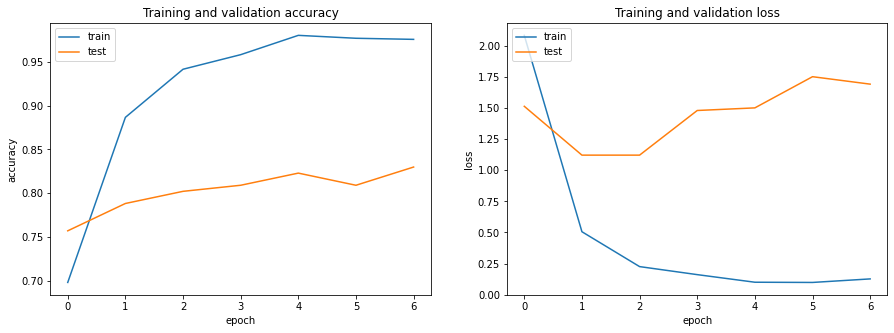

19/19 [==============================] - 4s 207ms/step
              precision    recall  f1-score   support

           0       0.73      0.83      0.77       190
           1       0.84      0.75      0.79       203
           2       0.91      0.90      0.91       207

    accuracy                           0.82       600
   macro avg       0.83      0.82      0.82       600
weighted avg       0.83      0.82      0.83       600



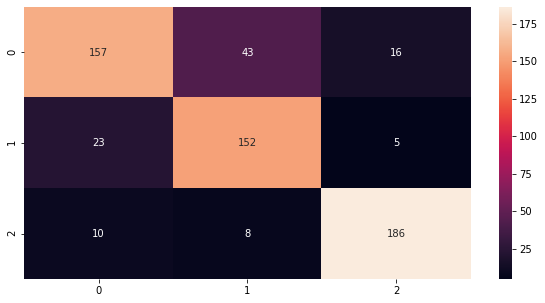

In [ ]:
show_performance(VGG16_v4, history_VGG16_v4)

19/19 [==============================] - 4s 203ms/step


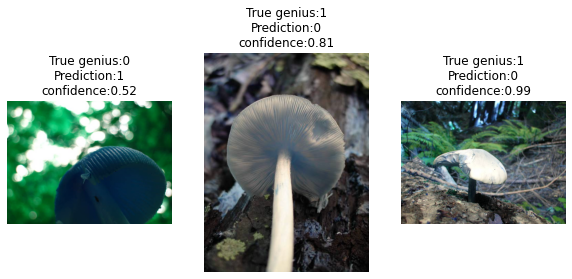

In [ ]:
show_wrong_predictions(VGG16_v4)

Conclusion : validation accuracy is 83% which is not improving from previous models. We still observe overfitting. 



##VGG16 - Transfer learning v5

In [ ]:
#VGG16 WITH TRANSFER LEARNING 

from keras.applications import VGG16

base_model=VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
#as include_top=False : pre-trained weights are only downloaded for convolution layers and no weights are downloaded for dense layers
for layer in base_model.layers:
  layer.trainable = False
VGG16_v5 = Sequential()
VGG16_v5.add(base_model)
VGG16_v5.add(Flatten())
VGG16_v5.add(Dense(1024, activation="relu"))
VGG16_v5.add(Dropout(0.5))
VGG16_v5.add(Dense(len(filtre_genus),activation="softmax"))

VGG16_v5.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_VGG16_v5= VGG16_v5.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                           callbacks=[callback],  validation_data=test_generator, validation_steps=test_generator.n//batch_size)

steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 20s 258ms/step - loss: 44.9489 - accuracy: 0.6107 - val_loss: 2.9213 - val_accuracy: 0.8160
Epoch 2/10
75/75 [==============================] - 19s 253ms/step - loss: 1.1320 - accuracy: 0.8930 - val_loss: 1.1938 - val_accuracy: 0.8229
Epoch 3/10
75/75 [==============================] - 19s 253ms/step - loss: 0.2486 - accuracy: 0.9410 - val_loss: 1.0392 - val_accuracy: 0.8455
Epoch 4/10
75/75 [==============================] - 19s 251ms/step - loss: 0.2704 - accuracy: 0.9442 - val_loss: 0.9999 - val_accuracy: 0.8281
Epoch 5/10
75/75 [==============================] - 19s 252ms/step - loss: 0.1886 - accuracy: 0.9507 - val_loss: 0.9839 - val_accuracy: 0.8438
Epoch 6/10
75/75 [==============================] - 19s 252ms/step - loss: 0.1649 - accuracy: 0.9600 - val_loss: 1.0505 - val_accuracy: 0.8507
Epoch 7/10
75/75 [==============================] - 19s 252ms/step - loss: 0.1199 - accuracy: 0.9693 - val_loss: 1.2410 - val_accuracy: 0.861

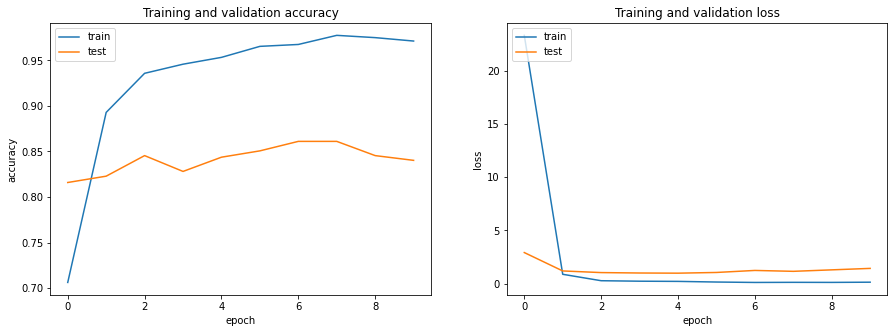

19/19 [==============================] - 4s 207ms/step
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       190
           1       0.82      0.83      0.83       203
           2       0.94      0.87      0.91       207

    accuracy                           0.83       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.83      0.84       600



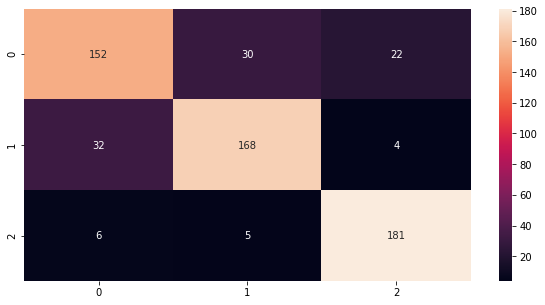

In [ ]:
show_performance(VGG16_v5, history_VGG16_v5)

19/19 [==============================] - 4s 205ms/step


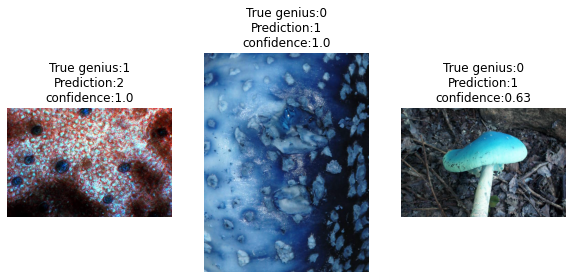

In [ ]:
show_wrong_predictions(VGG16_v5)

Conclusion : validation accuracy is 84% which is not improving from previous models. We still observe overfitting. 


#VGG19

##Create VGG19 Generators

In [ ]:

datagen= keras.preprocessing.image.ImageDataGenerator(preprocessing_function= keras.applications.vgg19.preprocess_input)

batch_size=32

#VGG16 needs images of size 224x224 
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="", 
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=(224,224), batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=(224,224), batch_size=batch_size)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


##VGG19 baseline

In [ ]:
from keras.applications import VGG19

base_model=VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))
#as include_top=False : pre-trained weights are only downloaded for convolution layers and no weights are downloaded for dense layers
for layer in base_model.layers:
  layer.trainable = False
VGG19 = Sequential()
VGG19.add(base_model)
VGG19.add(Flatten())
VGG19.add(Dense(100, activation="relu"))
VGG19.add(Dense(100, activation="relu"))
VGG19.add(Dense(100, activation="relu"))
VGG19.add(Dense(len(filtre_genus),activation="softmax"))

VGG19.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_VGG19= VGG19.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                         callbacks=[callback], validation_data=test_generator, validation_steps=test_generator.n//batch_size)

80142336/80134624 [==============================] - 0s 0us/step
steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 590s 8s/step - loss: 3.4941 - accuracy: 0.6249 - val_loss: 0.8963 - val_accuracy: 0.7795
Epoch 2/10
75/75 [==============================] - 20s 270ms/step - loss: 0.4296 - accuracy: 0.8945 - val_loss: 0.7824 - val_accuracy: 0.8194
Epoch 3/10
75/75 [==============================] - 20s 269ms/step - loss: 0.0944 - accuracy: 0.9657 - val_loss: 1.1264 - val_accuracy: 0.8108
Epoch 4/10
75/75 [==============================] - 20s 270ms/step - loss: 0.0838 - accuracy: 0.9746 - val_loss: 0.9465 - val_accuracy: 0.8524
Epoch 5/10
75/75 [==============================] - 20s 270ms/step - loss: 0.0600 - accuracy: 0.9892 - val_loss: 1.1113 - val_accuracy: 0.8281
Epoch 6/10
75/75 [==============================] - 20s 269ms/step - loss: 0.0827 - accuracy: 0.9813 - val_loss: 1.0323 - val_accuracy: 0.8524
Epoch 7/10
75/75 [==============================] - 20s 269ms/step - loss: 0.0277 - accuracy: 0.9945 - val_loss: 0.9242 - val_accuracy: 0.8663
E

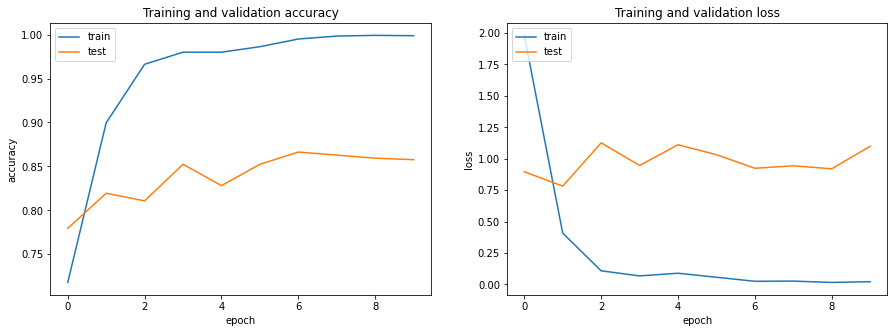

19/19 [==============================] - 4s 209ms/step
              precision    recall  f1-score   support

           0       0.81      0.57      0.67       190
           1       0.57      0.90      0.70       203
           2       0.96      0.67      0.79       207

    accuracy                           0.72       600
   macro avg       0.78      0.71      0.72       600
weighted avg       0.78      0.72      0.72       600



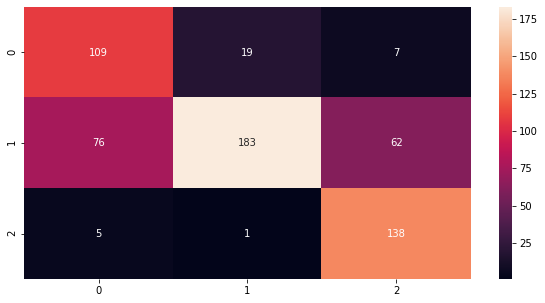

In [ ]:
show_performance(VGG19,history_VGG19)

Conclusion : validation accuracy is 78% which is less than VGG16_v4. We observe overfitting very quickly. 


#ResNet50

##Create Generators

In [ ]:
datagen= keras.preprocessing.image.ImageDataGenerator()

batch_size=32

#VGG16 needs images of size 224x224 
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="", 
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=(224,224), batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=(224,224), batch_size=batch_size)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


##ResNet50 - Baseline

In [ ]:
from keras.applications import ResNet50

base_model=ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
#as include_top=False : pre-trained weights are only downloaded for convolution layers and no weights are downloaded for dense layers
for layer in base_model.layers:
  layer.trainable = False
ResNet50 = Sequential()
ResNet50.add(base_model)
ResNet50.add(Flatten())
ResNet50.add(Dense(len(filtre_genus),activation="softmax"))  #activation="sigmoid"

#on test optimizer SGD
ResNet50.compile(optimizer=Adam(learning_rate=1e-2), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_ResNet50= ResNet50.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                             callbacks=[callback],  validation_data=test_generator, validation_steps=test_generator.n//batch_size)

steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 23s 269ms/step - loss: 78.6133 - accuracy: 0.6518 - val_loss: 116.5034 - val_accuracy: 0.6458
Epoch 2/10
75/75 [==============================] - 19s 254ms/step - loss: 19.6043 - accuracy: 0.9008 - val_loss: 34.1043 - val_accuracy: 0.8194
Epoch 3/10
75/75 [==============================] - 19s 255ms/step - loss: 5.3188 - accuracy: 0.9522 - val_loss: 45.5751 - val_accuracy: 0.8247
Epoch 4/10
75/75 [==============================] - 19s 255ms/step - loss: 3.8240 - accuracy: 0.9727 - val_loss: 42.5536 - val_accuracy: 0.8507
Epoch 5/10
75/75 [==============================] - 19s 253ms/step - loss: 3.0125 - accuracy: 0.9806 - val_loss: 44.4937 - val_accuracy: 0.8524
Epoch 6/10
75/75 [==============================] - 19s 253ms/step - loss: 2.1078 - accuracy: 0.9822 - val_loss: 57.1493 - val_accuracy: 0.8507
Epoch 7/10
75/75 [==============================] - 19s 254ms/step - loss: 2.6066 - accuracy: 0.9777 - val_loss: 63.5827 - val_accura

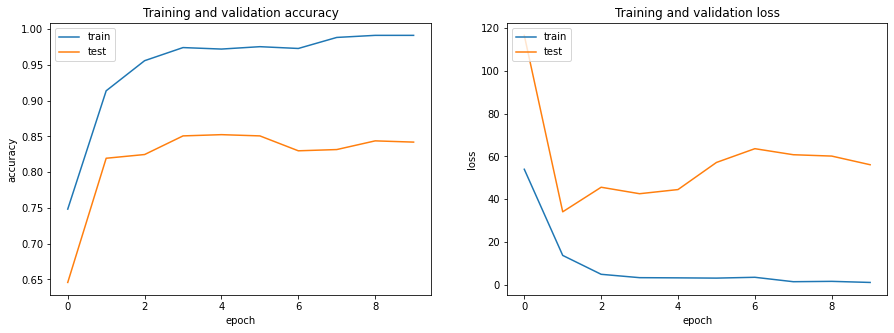

19/19 [==============================] - 4s 204ms/step
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       190
           1       0.81      0.82      0.82       203
           2       0.90      0.91      0.90       207

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



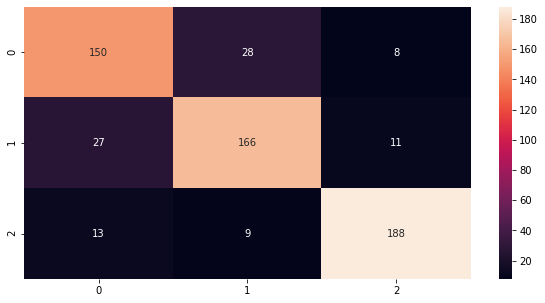

In [ ]:
show_performance(ResNet50, history_ResNet50)

Conclusion : validation accuracy is 84% which is not improving from previous models VGG16 and VGG19. We still observe overfitting. 


#EfficientNet

##Create Generators

In [ ]:
datagen= keras.preprocessing.image.ImageDataGenerator()

batch_size=32

train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="", 
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=(224,224), batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=(224,224), batch_size=batch_size)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


##EfficientNet B0

In [ ]:
#EFFICIENTNET MODEL

from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False, weights="imagenet")
#we freeze the pretrained weights
base_model.trainable = False
ENetB0=Sequential()
ENetB0.add(base_model)
ENetB0.add(GlobalAveragePooling2D())
ENetB0.add(Dropout(rate=0.2))
ENetB0.add(Dense(len(filtre_genus),activation="softmax"))

ENetB0.compile(optimizer=Adam(learning_rate=1e-2), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_ENetB0= ENetB0.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                           callbacks=[callback],validation_data=test_generator, validation_steps=test_generator.n//batch_size)

16711680/16705208 [==============================] - 0s 0us/step
steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 25s 265ms/step - loss: 0.5708 - accuracy: 0.7592 - val_loss: 0.3709 - val_accuracy: 0.8646
Epoch 2/10
75/75 [==============================] - 19s 252ms/step - loss: 0.2936 - accuracy: 0.8924 - val_loss: 0.4031 - val_accuracy: 0.8403
Epoch 3/10
75/75 [==============================] - 19s 249ms/step - loss: 0.2575 - accuracy: 0.9072 - val_loss: 0.3178 - val_accuracy: 0.8802
Epoch 4/10
75/75 [==============================] - 19s 248ms/step - loss: 0.2118 - accuracy: 0.9113 - val_loss: 0.3415 - val_accuracy: 0.8819
Epoch 5/10
75/75 [==============================] - 18s 246ms/step - loss: 0.2046 - accuracy: 0.9208 - val_loss: 0.3763 - val_accuracy: 0.8733
Epoch 6/10
75/75 [==============================] - 19s 248ms/step - loss: 0.2232 - accuracy: 0.9144 - val_loss: 0.3530 - val_accuracy: 0.8715
Epoch 7/10
75/75 [==============================] - 19s 250ms/step - loss: 0.1729 - accuracy: 0.9259 - val_loss: 0.3389 - val_accuracy: 0.8802

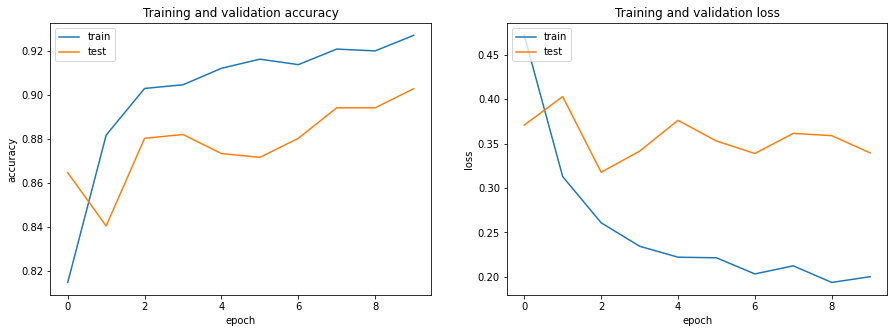

19/19 [==============================] - 4s 201ms/step
              precision    recall  f1-score   support

           0       0.87      0.88      0.87       190
           1       0.90      0.88      0.89       203
           2       0.94      0.95      0.94       207

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600



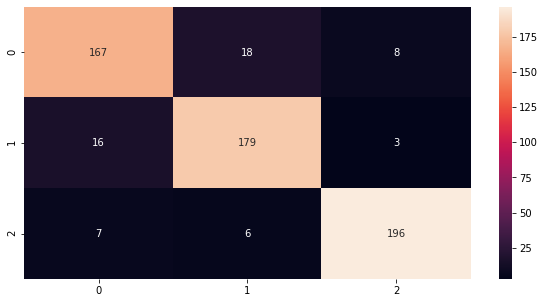

In [ ]:
show_performance(ENetB0, history_ENetB0)


19/19 [==============================] - 4s 196ms/step


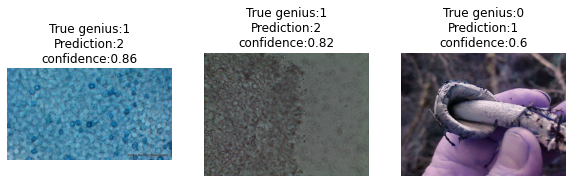

In [ ]:
show_wrong_predictions(ENetB0)

Conclusion : the validation accuracy is 90% which is already excellent for a first model !! Moreover the accuracy has not converged so it could be even more with 20 epochs. 

At this stage EfficientNet B0 is the best model to optimize

##EfficientNet B1

In [ ]:
#EfficientNet B1 MODEL

from tensorflow.keras.applications import EfficientNetB1

base_model = EfficientNetB1(include_top=False, weights="imagenet")
#we freeze the pretrained weights
base_model.trainable = False
ENetB1=Sequential()
ENetB1.add(base_model)
ENetB1.add(GlobalAveragePooling2D())
ENetB1.add(Dropout(rate=0.2))
ENetB1.add(Dense(len(filtre_genus),activation="softmax"))

ENetB1.compile(optimizer=Adam(learning_rate=1e-2), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_ENetB1= ENetB1.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                           callbacks=[callback], validation_data=test_generator, validation_steps=test_generator.n//batch_size)

27025408/27018416 [==============================] - 0s 0us/step
steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 27s 271ms/step - loss: 0.5743 - accuracy: 0.7503 - val_loss: 0.3354 - val_accuracy: 0.8802
Epoch 2/10
75/75 [==============================] - 19s 252ms/step - loss: 0.2581 - accuracy: 0.8990 - val_loss: 0.3447 - val_accuracy: 0.8750
Epoch 3/10
75/75 [==============================] - 19s 255ms/step - loss: 0.2457 - accuracy: 0.9094 - val_loss: 0.3487 - val_accuracy: 0.8698
Epoch 4/10
75/75 [==============================] - 19s 251ms/step - loss: 0.2065 - accuracy: 0.9273 - val_loss: 0.3378 - val_accuracy: 0.8872
Epoch 5/10
75/75 [==============================] - 19s 254ms/step - loss: 0.2105 - accuracy: 0.9222 - val_loss: 0.3565 - val_accuracy: 0.8785
Epoch 6/10
75/75 [==============================] - 19s 253ms/step - loss: 0.2225 - accuracy: 0.9195 - val_loss: 0.3558 - val_accuracy: 0.8837
Epoch 7/10
75/75 [==============================] - 19s 250ms/step - loss: 0.1882 - accuracy: 0.9279 - val_loss: 0.3900 - val_accuracy: 0.8750

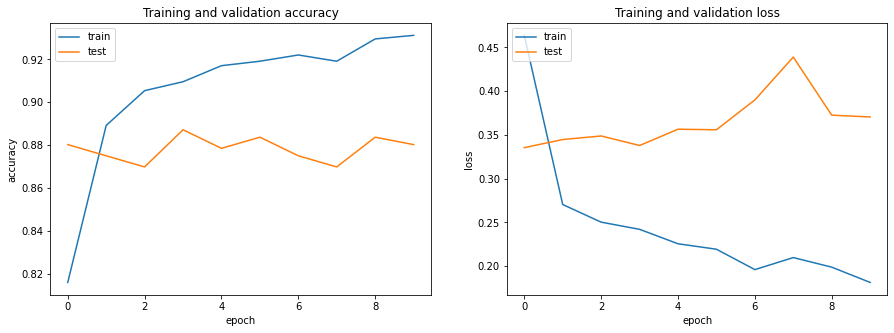

19/19 [==============================] - 4s 198ms/step
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       190
           1       0.86      0.83      0.84       203
           2       0.94      0.96      0.95       207

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



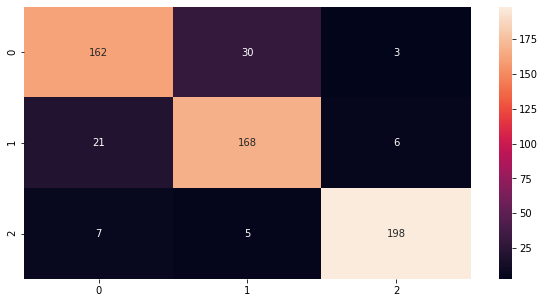

In [ ]:
show_performance(ENetB1, history_ENetB1)

Conclusion : with an accuracy of 88%, this model is not improving EfficientNet B0

##EfficientNet B7

In [ ]:
#EfficientNet B7 MODEL

from tensorflow.keras.applications import EfficientNetB7

base_model = EfficientNetB7(include_top=False, weights="imagenet")
#we freeze the pretrained weights
base_model.trainable = False
ENetB7=Sequential()
ENetB7.add(base_model)
ENetB7.add(GlobalAveragePooling2D())
ENetB7.add(Dropout(rate=0.2))
ENetB7.add(Dense(len(filtre_genus),activation="softmax"))

ENetB7.compile(optimizer=Adam(learning_rate=1e-2), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

epochs=10
print("steps per epoch:", train_generator.n//batch_size)

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history_ENetB7= ENetB7.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=train_generator.n//batch_size,
                           callbacks=[callback], validation_data=test_generator, validation_steps=test_generator.n//batch_size)

258080768/258076736 [==============================] - 1s 0us/step
steps per epoch: 75


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
75/75 [==============================] - 44s 364ms/step - loss: 0.5685 - accuracy: 0.7481 - val_loss: 0.3613 - val_accuracy: 0.8802
Epoch 2/10
75/75 [==============================] - 23s 311ms/step - loss: 0.3074 - accuracy: 0.8925 - val_loss: 0.3262 - val_accuracy: 0.8750
Epoch 3/10
75/75 [==============================] - 23s 312ms/step - loss: 0.2191 - accuracy: 0.9139 - val_loss: 0.3300 - val_accuracy: 0.8837
Epoch 4/10
75/75 [==============================] - 23s 310ms/step - loss: 0.2314 - accuracy: 0.9047 - val_loss: 0.4556 - val_accuracy: 0.8420
Epoch 5/10
75/75 [==============================] - 23s 312ms/step - loss: 0.2046 - accuracy: 0.9180 - val_loss: 0.3704 - val_accuracy: 0.8663
Epoch 6/10
75/75 [==============================] - 23s 308ms/step - loss: 0.1954 - accuracy: 0.9231 - val_loss: 0.3728 - val_accuracy: 0.8889
Epoch 7/10
75/75 [==============================] - 23s 308ms/step - loss: 0.1923 - accuracy: 0.9287 - val_loss: 0.3458 - val_accuracy: 0.8924

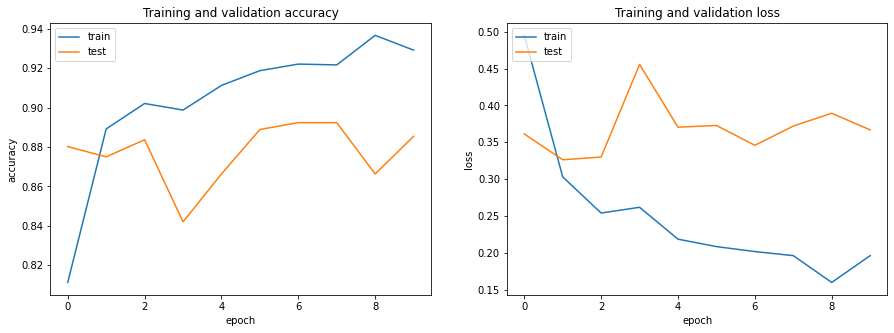

19/19 [==============================] - 5s 249ms/step
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       190
           1       0.86      0.88      0.87       203
           2       0.90      0.97      0.93       207

    accuracy                           0.89       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.89      0.88       600



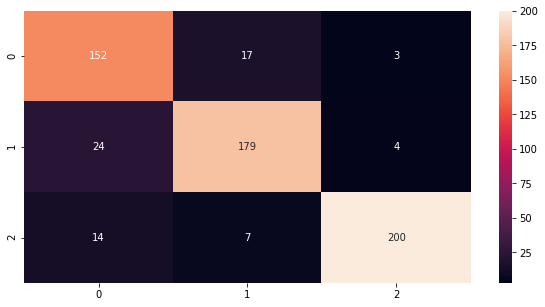

In [ ]:
show_performance(ENetB7, history_ENetB7)


Conclusion : with an accuracy of 88%, this model is not improving EfficientNet B0

#SUMMARY

In [ ]:
history=[]
history.append(history_VGG16_v1.history["val_accuracy"][-1])
history.append(history_VGG16_v2.history["val_accuracy"][-1])
history.append(history_VGG16_v3.history["val_accuracy"][-1])
history.append(history_VGG16_v4.history["val_accuracy"][-1])
history.append(history_VGG16_v5.history["val_accuracy"][-1])
history.append(history_VGG19.history["val_accuracy"][-1])
history.append(history_ResNet50.history["val_accuracy"][-1])
history.append(history_ENetB0.history["val_accuracy"][-1])
history.append(history_ENetB1.history["val_accuracy"][-1])
history.append(history_ENetB7.history["val_accuracy"][-1])

pd.DataFrame(history,columns=["Validation Accuracy"], index=["VGG16_v1","VGG16_v2","VGG16_v3","VGG16_v4","VGG16_v5","VGG19","ResNet50","ENetB0","ENetB1","ENetB7"])


,Validation Accuracy
VGG16_v1,0.838542
VGG16_v2,0.809028
VGG16_v3,0.803819
VGG16_v4,0.829861
VGG16_v5,0.840278
VGG19,0.857639
ResNet50,0.842014
ENetB0,0.902778
ENetB1,0.880208
ENetB7,0.885417


Conclusion : EfficientNet B0 gives an accuracy of 90% with 3 genus with nearly no optimization !

Next steps:

- Try optimizing the above models with 3 genus by modifying the layers on top (reduce the overfitting with Dropout layer with higher rate, modify the number of units, understand the effect of each parameter..)
- With 3 genus, when there is overfitting, try data augmentation in the generators
- With 3 genus, try fine-tuning existing models (VGG16, EfficientNet, other..) by unfreezing latest blocks. 
- With 3 genus, understand the impact of some parameters : learning rates, choice of the optimizers, rescaling in the generators, batch size, etc..
- Find an automated solution to filter images not representing mushrooms
- Expand to 35 genus when the best model is found
- Improve performance functions and analysis of results by class

#Diagnostics functions

In [ ]:
#show model performance
def show_performance(my_model,history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  x_epochs=range(len(history.history["accuracy"]))
  plt.plot(x_epochs, history.history["accuracy"])
  plt.plot(x_epochs, history.history["val_accuracy"])
  plt.title("Training and validation accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(1,2,2)
  x_epochs=range(len(history.history["loss"]))
  plt.plot(x_epochs, history.history["loss"])
  plt.plot(x_epochs, history.history["val_loss"])
  plt.title("Training and validation loss")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes
  print(metrics.classification_report(y_test_class, test_pred_class))

  df_cm=pd.DataFrame(metrics.confusion_matrix(test_pred_class,y_test_class))
  plt.figure(figsize = (10,5))
  sns.heatmap(df_cm, annot=True, fmt="d")


In [ ]:
def show_good_predictions(preprocess_input)
  
  correct_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] == y_test_class[i]):
      correct_indexes.append(i)

  j=1
  plt.figure(figsize=(10, 10))
  for i in np.random.choice(correct_indexes, size=3):
    img=cv2.imread(X_test.img_path.iloc[i])
    plt.subplot(1,3,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(y_test_class[i]) +
              "\n"+ "Prediction:" + str(test_pred_class[i]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))

In [ ]:
#Show wrong predictions
def show_wrong_predictions(my_model):
  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes

  error_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] != y_test_class[i]):
      error_indexes.append(i)

  j=1
  plt.figure(figsize=(10, 10))
  for i in np.random.choice(error_indexes, size=3):
    img=cv2.imread(X_test.img_path.iloc[i])
    plt.subplot(1,3,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(y_test_class[i]) +
              "\n"+ "Prediction:" + str(test_pred_class[i]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))